# 1. DATA EXPLORATION

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Preprocessing and Feature Engineering
from textblob import TextBlob
import re 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
df = pd.read_excel('sentences_with_sentiment.xlsx')

In [3]:
df = df[['Sentence','Positive','Negative','Neutral']].drop_duplicates()

In [4]:
(df ['Positive']+df ['Negative']+df ['Neutral']).value_counts()

1    236
dtype: int64

In [5]:
df['label'] = df[['Positive','Negative','Neutral']].idxmax(axis=1)

In [6]:
df[['Sentence','label']].to_excel('sentiment_sentences.xlsx',index=False)

In [7]:
df_label_count = df['label'].value_counts().reset_index()

In [8]:
df_label_count

,index,label
0,Positive,140
1,Neutral,64
2,Negative,32


In [9]:
pd.set_option('max_colwidth',None)
df[['Sentence','label']].sample(10)

,Sentence,label
90,"Furthermore, encouraging signs of a prolonged OS were seen in patients treated with the combination of lenvatinib and everolimus combination therapy as per the primary analysis as well as the two updated analyses that span a more than 1-year period.",Positive
113,Maintenance of the treatment effect in year 3 and 4 was supported by long-term data from CLARITY EXT.,Positive
215,"The recommendation has been further supported by data from the lixisenatide file, showing that no statistically significant differences are observed between pre-breakfast or pre-dinner dosing of lixisenatide.",Neutral
85,"Sarilumab is associated with infections (including serious infections), decrease in ANC and platelet count, and increase in ALT and lipids, all of which are events consistent with the known effect of IL-6 inhibition, and with injection site reactions, consistent with a SC route of administration.",Neutral
254,SOF/VEL/VOX for 12 weeks has shown excellent efficacy in patients that have previously failed a regimen containing an NS5A inhibitor.,Positive
240,"Nevertheless, the responder analysis indicates a benefit for CHF 5993 compared with Foster on TDI symptoms for a greater proportion of patients.",Positive
87,The efficacy of the combination of lenvatinib with everolimus has been shown.,Positive
239,"TDI focal score, the third co-primary endpoint, had a clinically relevant improvement with both treatments, but the mean difference between treatments in TDI focal score at week 26 was not statistically significant.",Neutral
59,"With regard to immunogenicity, the incidence and titre distribution of ADAs were compared and seemed similar for SB5 and Humira, with about half of all subjects developing neutralising antibodies in each treatment group.",Positive
172,"Also the psoriasis study met the primary endpoint with a point estimate of difference of 2% with narrow CIs, indicating similarity.",Positive


<AxesSubplot: >

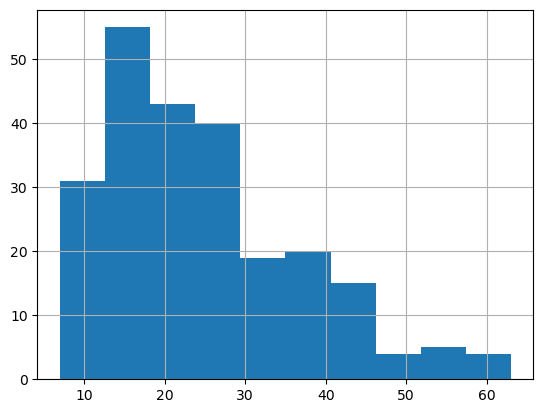

In [10]:
df['Sentence'].apply(lambda x:len(x.split(' '))).hist()

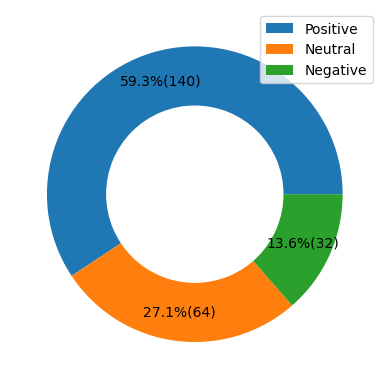

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # display number and percentage
        return '{p:.1f}%({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(df_label_count['label'],pctdistance=0.8,autopct=make_autopct(df_label_count['label']))
plt.pie([1],radius=0.6,colors='w')
plt.legend(df_label_count['index'],loc='upper right')

In [12]:
pd.options.display.notebook_repr_html=False  # 表格显示
plt.rcParams['figure.dpi'] = 75  # 图形分辨率
sns.set_theme(style='darkgrid')  # 图形主题

<AxesSubplot: xlabel='label', ylabel='count'>

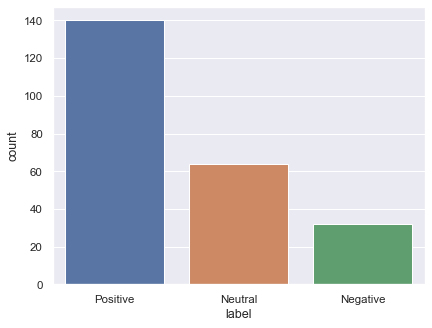

In [13]:
sns.countplot(x='label',data=df)

## 1.1 Preprocessing: Clean Texts

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
import pandas as pd
from bs4 import BeautifulSoup
import re

In [12]:
def from_sentence(text):
    text_blob = TextBlob(text)
    return ' '.join(text_blob.words)

def no_stopwords(text):
    stop_words = stopwords.words('english')
    stop_words = list(set(stop_words)-{'no','nor','not',"don't","aren't",
                                      "couldn't","didn't", "doesn't", "hadn't",
                                      "hasn't",  "haven't", "isn't",  "mightn't",
                                      "mustn't",  "needn't",  "shan't", "shouldn't",
                                       "wasn't", 'weren', "weren't",  "won't", "wouldn't"})
    clean_tokens = [t for t in text.split() if re.match(r'[^\W\d]*\w*$',t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word.lower() for word in clean_s.split() if word.lower() not in stop_words]
    return clean_mess

def normalization(text_list):
    lem = WordNetLemmatizer()
    normalized_words = []
    for word in text_list:
        normalized_text = lem.lemmatize(word,'v')
        normalized_words.append(normalized_text)
    return normalized_words

In [13]:
df['clean_sentence'] = df['Sentence'].apply(lambda x:' '.join(normalization(no_stopwords(from_sentence(x)))))

In [17]:
def review_to_words(raw_review):    
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z\d]", " ", review_text) 
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    # 4. In Python, searching a set is much faster than searching
    stops = set(stopwords.words("english"))                  
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return ' '.join(meaningful_words)

In [18]:
df['clean_text'] = df['Sentence'].apply(lambda x:review_to_words(x))

/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


## 1.2 Word Cloud

In [19]:
from wordcloud import STOPWORDS,WordCloud
from collections import Counter

stop_words = STOPWORDS
#stop_words.update(['data','patients','study','studies','results','considered','will'])
#wordcount = Counter([word for word in ' '.join(df['clean_text']).split(' ') \
#                     if len(word) > 1])
wordcount = Counter([word for word in ' '.join(df['clean_sentence']).split(' ')\
                     if len(word) > 1])

In [20]:
def get_plt(data, title):
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    fig, ax = plt.subplots()
    ax.barh(range(len(x)), y, color='gold')
    ax.set_yticks(range(len(x)))
    ax.set_yticklabels(x)
    plt.title(title, fontsize=10)
    plt.ylabel("word")
    plt.xlabel('count')
    plt.show()

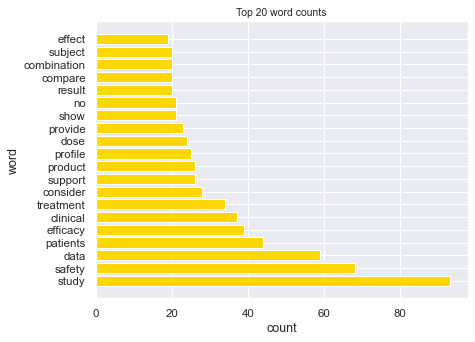

In [21]:
get_plt(wordcount.most_common(20),'Top 20 word counts')

In [34]:
from PIL import Image
import numpy as np
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt

cloud_mask = np.array(Image.open("/Users/yuxueqi/Downloads/心形.png"))

In [36]:
wc = WordCloud(stopwords=stop_words)

wc = WordCloud(background_color="white", 
    mask=cloud_mask)
wc.generate(' '.join(df[df['label']=='Positive']['clean_sentence']))

wc.to_file("positive_wordcloud.png")

In [39]:
wc.generate(' '.join(df[df['label']=='Negative']['clean_sentence']))

wc.to_file("negative_wordcloud.png")

In [40]:
wc.generate(' '.join(df[df['label']=='Neutral']['clean_sentence']))

wc.to_file("neutral_wordcloud.png")

# 2. Rule Based Methods

## 2.1 VADER FROM RULES

In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,confusion_matrix

In [37]:
def plot_prediction_bar(column,method):
    '''
    bar plot of prediction vs truth
    '''
    confusion_mat = confusion_matrix(df['label'],df[column])

    ind = [0,5,10]    # the x locations for the groups
    width = 1       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(ind, confusion_mat[2,:],width, color='#d62728')#, yerr=menStd)
    p2 = plt.bar(ind, confusion_mat[1,:], width,bottom = confusion_mat[2,:])#, yerr=womenStd)
    p3 = plt.bar(ind, confusion_mat[0,:], width, bottom = confusion_mat[2,:]+confusion_mat[1,:])
    
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.title('Prediction by '+method)
    plt.xticks(ind, ('Negative','Neutral','Positive'))
    plt.yticks(np.arange(0, 101, 20))
    plt.legend((p1[0], p2[0], p3[0]), ('Positive', 'Neutral', 'Negative'))

    plt.show()

In [31]:
df['vadar_score'] = df['clean_sentence'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
df['vadar_result'] = df['vadar_score'].apply(lambda x:'Positive' if x>0.05 else 'Negative' if x<-0.05 else 'Neutral')

In [32]:
df['vadar_result'].value_counts()

Positive    134
Neutral      59
Negative     43
Name: vadar_result, dtype: int64

In [33]:
accuracy_score(df['label'],df['vadar_result'])

0.5127118644067796

In [34]:
print(classification_report(df['label'],df['vadar_result']))

              precision    recall  f1-score   support

    Negative       0.23      0.31      0.27        32
     Neutral       0.39      0.36      0.37        64
    Positive       0.66      0.63      0.64       140

    accuracy                           0.51       236
   macro avg       0.43      0.43      0.43       236
weighted avg       0.53      0.51      0.52       236



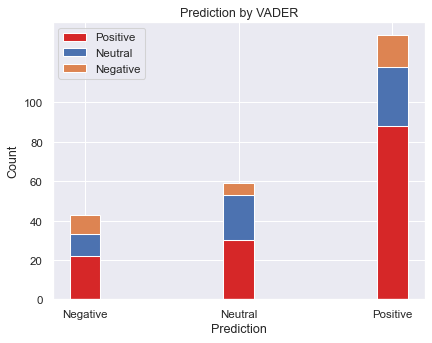

In [38]:
plot_prediction_bar('vadar_result','VADER')

## 2.2 Opinion Lexicon Method

In [105]:
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import sentiwordnet
from nltk.corpus import wordnet
import nltk
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score,\
recall_score,accuracy_score,roc_auc_score,classification_report

from nltk.corpus import opinion_lexicon
import numpy as np
import matplotlib.pyplot as plt

In [52]:
def score_from_opinion_lexicon(text):
    pos_words = set(text.split(' ')).intersection(set(opinion_lexicon.positive()))
    neg_words = set(text.split(' ')).intersection(set(opinion_lexicon.negative()))
    pos_num = len(pos_words)
    neg_num = len(neg_words)
    score = pos_num - neg_num
    return {'score':score,'pos_words':pos_words,'neg_words':neg_words}

In [53]:
df['score_opnion_lexicon'] = df['clean_sentence'].apply(lambda x:score_from_opinion_lexicon(x))

In [54]:
df['predicted_opnion_lexicon'] = df['score_opnion_lexicon'].apply(lambda x:'Positive' if x['score']>0 \
                                                                  else 'Negative' if x['score']<0 else 'Neutral')

In [55]:
df['predicted_opnion_lexicon'].value_counts()

Positive    100
Neutral      91
Negative     45
Name: predicted_opnion_lexicon, dtype: int64

In [66]:
df['predicted_opnion_lexicon']

0      Positive
1      Positive
2      Positive
3      Positive
4      Positive
         ...   
261     Neutral
262    Negative
263     Neutral
264    Negative
265    Negative
Name: predicted_opnion_lexicon, Length: 236, dtype: object

In [80]:
df['predicted_opnion_lexicon'].value_counts()

Positive    100
Neutral      91
Negative     45
Name: predicted_opnion_lexicon, dtype: int64

In [70]:
df['score_opnion_lexicon'].apply(lambda x:x['pos_words']).value_counts().head(11)

{}              112
{support}        14
{consistent}      7
{regard}          5
{sufficient}      4
{adequate}        4
{benefit}         4
{durable}         3
{available}       3
{well}            3
{important}       3
Name: score_opnion_lexicon, dtype: int64

In [65]:
df['score_opnion_lexicon'].apply(lambda x:x['neg_words']).value_counts().head(11)

{}                162
{concern}          10
{issue}             5
{risk}              4
{severe}            3
{adverse}           3
{pain}              2
{atrophy}           2
{inconsistent}      2
{severity}          2
{limit}             2
Name: score_opnion_lexicon, dtype: int64

In [56]:
print(classification_report(df['label'],df['predicted_opnion_lexicon']))

              precision    recall  f1-score   support

    Negative       0.38      0.53      0.44        32
     Neutral       0.29      0.41      0.34        64
    Positive       0.71      0.51      0.59       140

    accuracy                           0.48       236
   macro avg       0.46      0.48      0.46       236
weighted avg       0.55      0.48      0.50       236



In [74]:
def text_score(text,stop_word_list):
    #create word lsit
    #nltk.pos_tag是打标签
    ttt = nltk.pos_tag([i for i in word_tokenize(str(text).lower()) if i not in stop_word_list])
    word_tag_fq = nltk.FreqDist(ttt)
    wordlist = word_tag_fq.most_common()

    key = []
    part = []
    frequency = []
    for i in range(len(wordlist)):
        key.append(wordlist[i][0][0])
        part.append(wordlist[i][0][1])
        frequency.append(wordlist[i][1])
    textdf = pd.DataFrame({'key':key,
                      'part':part,
                      'frequency':frequency},
                      columns=['key','part','frequency'])

    #编码
    n = ['NN','NNP','NNPS','NNS','UH']
    v = ['VB','VBD','VBG','VBN','VBP','VBZ']
    a = ['JJ','JJR','JJS']
    r = ['RB','RBR','RBS','RP','WRB']

    for i in range(len(textdf['key'])):
        z = textdf.iloc[i,1]

        if z in n:
            textdf.iloc[i,1]='n'
        elif z in v:
            textdf.iloc[i,1]='v'
        elif z in a:
            textdf.iloc[i,1]='a'
        elif z in r:
            textdf.iloc[i,1]='r'
        else:
            textdf.iloc[i,1]=''
            
    #Calculate sentiment score of a sentence
    score = []
    for i in range(len(textdf['key'])):
        m = list(swn.senti_synsets(textdf.iloc[i,0],textdf.iloc[i,1]))
        s = 0
        ra = 0
        if len(m) > 0:
            for j in range(len(m)):
                s += (m[j].pos_score()-m[j].neg_score())/(j+1)
                ra += 1/(j+1)
            score.append(s/ra)
        else:
            score.append(0)
        #pd.concat([textdf,pd.DataFrame({'score':score})],axis=1),    
    return sum(score)


In [61]:
stop_words = stopwords.words('english')
stop_words = list(set(stop_words)-{'no','nor','not',"don't","aren't",
                                      "couldn't","didn't", "doesn't", "hadn't",
                                      "hasn't",  "haven't", "isn't",  "mightn't",
                                      "mustn't",  "needn't",  "shan't", "shouldn't",
                                       "wasn't", 'weren', "weren't",  "won't", "wouldn't"})

In [76]:
df['Sentence'].apply(lambda x:text_score(x,stop_words)).value_counts()

 0.000    199
 0.375     15
 0.125     13
-0.500      5
 0.250      3
-0.125      1
Name: Sentence, dtype: int64

# MACHINE LEARNING METHODS

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,confusion_matrix

In [194]:
def plot_prediction_test_train_bar(column,index_train,index_test,method):
    '''
    bar plot of prediction vs truth
    '''
    confusion_mat_train = confusion_matrix(df['label'][index_train],df[column][index_train])
    confusion_mat_test = confusion_matrix(df['label'][index_test],df[column][index_test])

    ind_train = [0,5,10]  
    ind_test = [1.5,6.5,11.5]
    # the x locations for the groups
    width = 1       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(ind_train, confusion_mat_train[2,:],width, color='#d62728')
    p2 = plt.bar(ind_train, confusion_mat_train[1,:], width,bottom = confusion_mat_train[2,:],color = 'navy')
    p3 = plt.bar(ind_train, confusion_mat_train[0,:], width, bottom = confusion_mat_train[2,:]+confusion_mat_train[1,:],color='purple')
    
    p4 = plt.bar(ind_test, confusion_mat_test[2,:],width, color='#d62728')
    p5 = plt.bar(ind_test, confusion_mat_test[1,:], width,bottom = confusion_mat_test[2,:],color='navy')
    p6 = plt.bar(ind_test, confusion_mat_test[0,:], width,bottom = confusion_mat_test[2,:]+confusion_mat_test[1,:],color='purple')
    
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.title('Prediction by '+method)
    plt.xticks([1,6,11],('Negative','Neutral','Positive'))
    plt.yticks(np.arange(0, 101, 20))
    plt.legend((p1[0], p2[0], p3[0]), ('Positive', 'Neutral', 'Negative'))

    plt.show()

In [16]:
X=df['clean_sentence']
y=df['label'].map({'Positive':1,'Negative':-1,'Neutral':0})
X_train, X_test, y_train, y_test=train_test_split(X, y,test_size=0.2,random_state=0)

In [134]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2))

X_train_transformed=tfidf_vec.fit_transform(X_train)
X_test_transformed=tfidf_vec.transform(X_test)

In [107]:
from gensim.models import word2vec
import numpy as np
train_sent = X_train.apply(lambda x:x.split(' ')).tolist()
model = word2vec.Word2Vec(train_sent,window = 5, vector_size=500,epochs = 100,min_count=1)
def compute_doc_vec_single(sentence):
    vec = np.zeros((model.layer1_size,),dtype=np.float32)
    n = 0
    for word in sentence:
        if word in model.wv:
            vec += model.wv[word]
            n += 1 
    return vec/n
X_train_w2v = X_train.apply(lambda x:compute_doc_vec_single(x.split(' ')))
X_test_w2v = X_test.apply(lambda x:compute_doc_vec_single(x.split(' ')))

In [108]:
train_w2v = X_train_w2v.apply(pd.Series)
test_w2v = X_test_w2v.apply(pd.Series)

In [21]:
# Naive Bayes Model
nb=MultinomialNB()
nb.fit(X_train_transformed, y_train)

MultinomialNB()

In [46]:
print(classification_report(y_test,nb.predict(X_test_transformed),target_names=['Negative','Neutral','Positive']))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         8
     Neutral       0.00      0.00      0.00        11
    Positive       0.60      1.00      0.75        29

    accuracy                           0.60        48
   macro avg       0.20      0.33      0.25        48
weighted avg       0.37      0.60      0.46        48



/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [47]:
# Model Evaluation
print(f'Test Score: {nb.score(X_test_transformed, y_test)}')
print(f'Train Score: {nb.score(X_train_transformed, y_train)}')

Test Score: 0.6041666666666666
Train Score: 0.8191489361702128


In [116]:
df['Predicted_NB'] = nb.predict(tfidf_vec.transform(X))
df['Predicted_NB'] = df['Predicted_NB'].map({1:'Positive',0:'Neutral',-1:'Negative'})

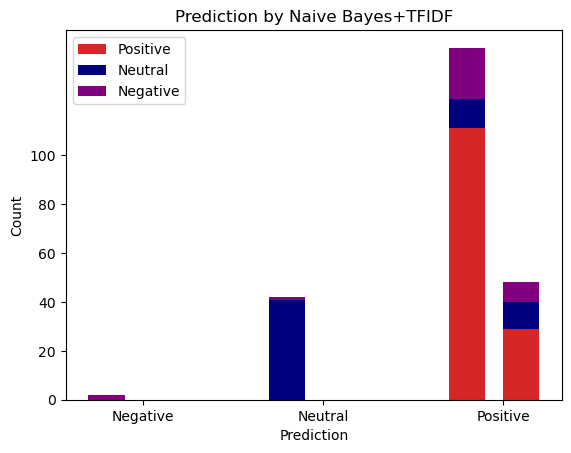

In [195]:
plot_prediction_test_train_bar('Predicted_NB',X_train.index,X_test.index,'Naive Bayes+TFIDF')

In [71]:
accuracy_score(df['label'],df['Predicted_NB'])

0.7754237288135594

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
lr = LogisticRegression()
lr.fit(X_train_transformed, y_train)
#accuracy_score(lr.predict(X_test_transformed),y_test)

print(classification_report(lr.predict(X_test_transformed),y_test,target_names=['Negative','Neutral','Positive']))

              precision    recall  f1-score   support

    Negative       0.25      1.00      0.40         2
     Neutral       0.00      0.00      0.00         0
    Positive       1.00      0.63      0.77        46

    accuracy                           0.65        48
   macro avg       0.42      0.54      0.39        48
weighted avg       0.97      0.65      0.76        48



/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [216]:
rf = RandomForestClassifier(max_depth=100,n_estimators=1000,max_features=600)
rf.fit(X_train_transformed, y_train)
accuracy_score(rf.predict(X_test_transformed),y_test)
print(classification_report(y_test,rf.predict(X_test_transformed),target_names=['Negative','Neutral','Positive']))

              precision    recall  f1-score   support

    Negative       1.00      0.25      0.40         8
     Neutral       0.43      0.27      0.33        11
    Positive       0.69      0.93      0.79        29

    accuracy                           0.67        48
   macro avg       0.71      0.48      0.51        48
weighted avg       0.68      0.67      0.62        48



In [217]:
df['Predicted_rf'] = rf.predict(tfidf_vec.transform(X))
df['Predicted_rf'] = df['Predicted_rf'].map({1:'Positive',0:'Neutral',-1:'Negative'})

In [218]:
accuracy_score(df['label'],df['Predicted_rf'])

0.9322033898305084

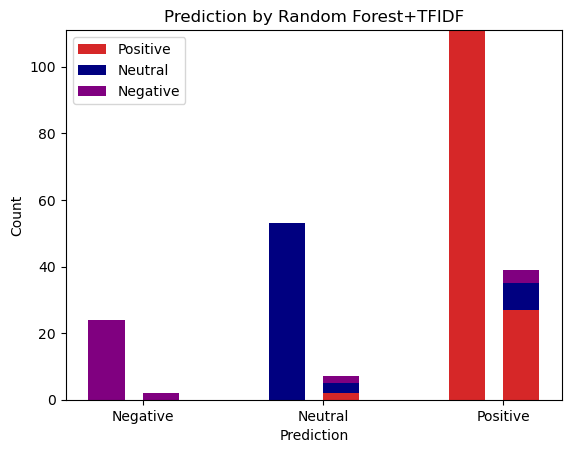

In [221]:
plot_prediction_test_train_bar('Predicted_rf',X_train.index,X_test.index,'Random Forest+TFIDF')

In [242]:
rf_w2v = RandomForestClassifier(max_depth=100,n_estimators=1000,max_features=200)
rf_w2v.fit(train_w2v,y_train)

RandomForestClassifier(max_depth=100, max_features=200, n_estimators=1000)

In [243]:
accuracy_score(rf_w2v.predict(test_w2v),y_test)
print(classification_report(y_test,rf_w2v.predict(test_w2v),target_names=['Negative','Neutral','Positive']))

              precision    recall  f1-score   support

    Negative       1.00      0.25      0.40         8
     Neutral       0.38      0.27      0.32        11
    Positive       0.68      0.90      0.78        29

    accuracy                           0.65        48
   macro avg       0.69      0.47      0.50        48
weighted avg       0.67      0.65      0.61        48



In [244]:
df['Predicted_rf_w2v'] = rf_w2v.predict(X.apply(lambda x:compute_doc_vec_single(x.split(' '))).apply(pd.Series))
df['Predicted_rf_w2v'] = df['Predicted_rf_w2v'].map({1:'Positive',0:'Neutral',-1:'Negative'})

In [245]:
accuracy_score(df['label'],df['Predicted_rf_w2v'])

0.9279661016949152

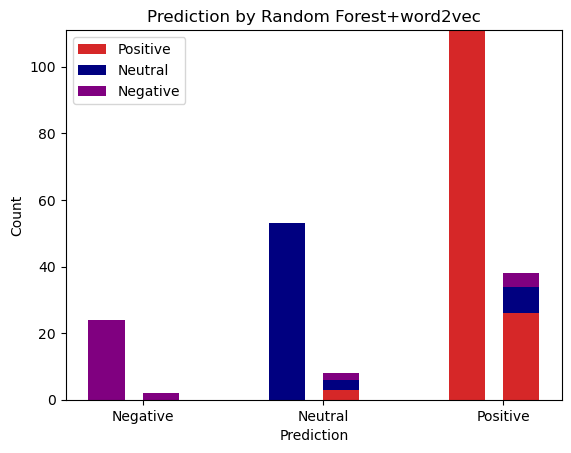

In [246]:
plot_prediction_test_train_bar('Predicted_rf_w2v',X_train.index,X_test.index,'Random Forest+word2vec')

In [255]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(max_depth=1000,n_estimators=1000,learning_rate=0.01)
lgb_model.fit(X_train_transformed,y_train)

LGBMClassifier(learning_rate=0.01, max_depth=1000, n_estimators=1000)

In [256]:
df['Predicted_lgb'] = lgb_model.predict(tfidf_vec.transform(X))
df['Predicted_lgb'] = df['Predicted_lgb'].map({1:'Positive',0:'Neutral',-1:'Negative'})

In [257]:
print(classification_report(y_test,lgb_model.predict(X_test_transformed),target_names=['Negative','Neutral','Positive']))

              precision    recall  f1-score   support

    Negative       0.67      0.25      0.36         8
     Neutral       0.20      0.09      0.13        11
    Positive       0.60      0.83      0.70        29

    accuracy                           0.56        48
   macro avg       0.49      0.39      0.39        48
weighted avg       0.52      0.56      0.51        48



In [258]:
print(classification_report(y_train,lgb_model.predict(X_train_transformed),target_names=['Negative','Neutral','Positive']))

              precision    recall  f1-score   support

    Negative       0.92      0.46      0.61        24
     Neutral       0.80      0.38      0.51        53
    Positive       0.70      0.95      0.81       111

    accuracy                           0.73       188
   macro avg       0.81      0.60      0.64       188
weighted avg       0.76      0.73      0.70       188



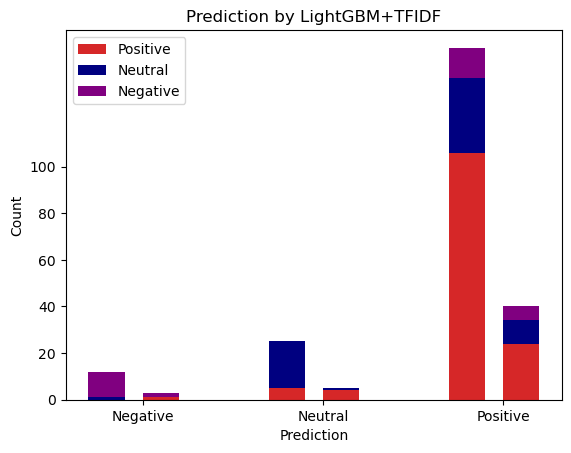

In [259]:
plot_prediction_test_train_bar('Predicted_lgb',X_train.index,X_test.index,'LightGBM+TFIDF')

In [276]:
accuracy_score(df['label'],df['Predicted_lgb'])

0.923728813559322

In [272]:
lgb_model_w2v = lgb.LGBMClassifier(max_depth=50,n_estimators=1000,learning_rate=0.01)
lgb_model_w2v.fit(train_w2v,y_train)

LGBMClassifier(learning_rate=0.01, max_depth=50, n_estimators=1000)

In [273]:
df['Predicted_lgb_w2v'] = lgb_model_w2v.predict(X.apply(lambda x:compute_doc_vec_single(x.split(' '))).apply(pd.Series))
df['Predicted_lgb_w2v'] = df['Predicted_lgb_w2v'].map({1:'Positive',0:'Neutral',-1:'Negative'})

In [275]:
accuracy_score(df['label'],df['Predicted_lgb_w2v'])

0.9279661016949152

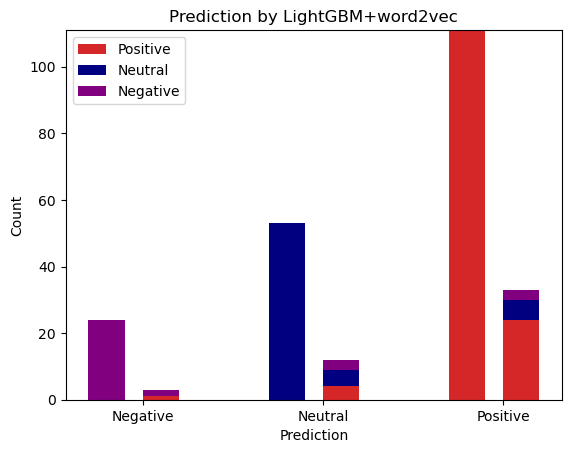

In [277]:
plot_prediction_test_train_bar('Predicted_lgb_w2v',X_train.index,X_test.index,'LightGBM+word2vec')

# Deep Learning Methods

In [278]:
from keras.layers import Dense
from tensorflow.python.keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import pandas as pd

In [280]:
from collections import Counter
counts = Counter()
for i,review in enumerate(df['clean_sentence']):
    counts.update(review.split())
words = sorted(counts, key=counts.get, reverse=True)

nb_chars = len(words)
print(nb_chars)
word_to_int = {word: i for i, word in enumerate(words, 1)}
int_to_word = {i: word for i, word in enumerate(words, 1)}

1067


In [282]:
mapped_reviews = []
for review in df['clean_sentence']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])

# 打印示例
print('Original text:',df.loc[0]['clean_sentence'])
print('Mapped text:',mapped_reviews[0])


Original text: result 2nd line treatment show orr 33 patients durable responses result apparent pfs plateau
Mapped text: [16, 231, 74, 7, 14, 533, 534, 4, 232, 314, 16, 535, 180, 536]


In [283]:
length_sent = []
for i in range(len(mapped_reviews)):
    length_sent.append(len(mapped_reviews[i]))

sequence_length = max(length_sent)

In [284]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x = pad_sequences(maxlen=sequence_length, sequences=mapped_reviews, padding="post", value=0)
y = df['label'].values
y = np.array(pd.get_dummies(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)

In [285]:
embedding_vector_length=100
max_review_length=30
model = Sequential()
model.add(Embedding(input_dim=nb_chars+1, output_dim=max_review_length, input_length = embedding_vector_length))

model.add(SimpleRNN(50, return_sequences=False))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(x_train,\
          y_train,\
          batch_size=256,\
          epochs=50,\
          validation_data=(x_test,y_test))
model.summary()

Epoch 1/50


2022-10-19 22:50:40.507750: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 535ms/step - loss: 1.0961 - acc: 0.3723 - val_loss: 1.0269 - val_acc: 0.6042
Epoch 2/50
1/1 [==============================] - 0s 22ms/step - loss: 1.0121 - acc: 0.5957 - val_loss: 0.9827 - val_acc: 0.6042
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 0.9554 - acc: 0.5904 - val_loss: 0.9572 - val_acc: 0.6042
Epoch 4/50
1/1 [==============================] - 0s 22ms/step - loss: 0.9242 - acc: 0.5904 - val_loss: 0.9473 - val_acc: 0.6042
Epoch 5/50
1/1 [==============================] - 0s 21ms/step - loss: 0.9040 - acc: 0.5904 - val_loss: 0.9454 - val_acc: 0.6042
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8780 - acc: 0.5957 - val_loss: 0.9503 - val_acc: 0.6042
Epoch 7/50
1/1 [==============================] - 0s 22ms/step - loss: 0.8351 - acc: 0.6117 - val_loss: 0.9680 - val_acc: 0.6042
Epoch 8/50
1/1 [==============================] - 0s 23ms/step - loss: 0.7677 - acc: 0.6649 - val_loss: 1.0

In [306]:
df['Predicted_rnn'] = pd.DataFrame(model.predict(x)).idxmax(axis=1).tolist()
df['Predicted_rnn'] = df['Predicted_rnn'].map({2:'Positive',1:'Neutral',0:'Negative'})

8/8 [==============================] - 0s 2ms/step


In [307]:
df['Predicted_rnn'].value_counts()

Positive    138
Neutral      67
Negative     31
Name: Predicted_rnn, dtype: int64

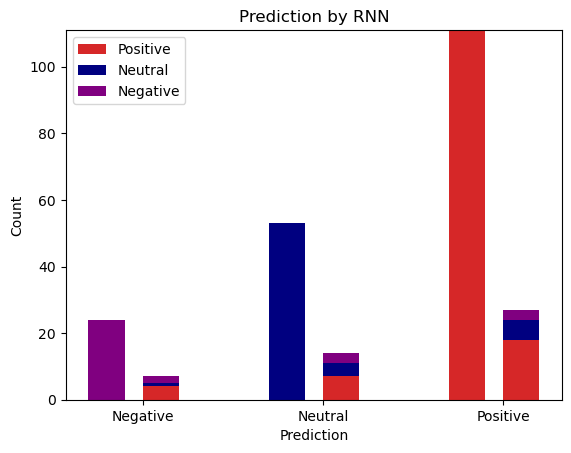

0.8983050847457628


In [309]:
plot_prediction_test_train_bar('Predicted_rnn',X_train.index,X_test.index,'RNN')
print(accuracy_score(df['label'],df['Predicted_rnn']))

In [33]:
#LSTM拟合

In [310]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import *

In [311]:
import pickle

In [336]:
def load_data(df, input_shape=20):
    # 标签及词汇表
    labels, vocabulary = list(df['label'].unique()), list(df['clean_sentence'].unique())
    # 构造字符级别的特征
    string = ''
    for word in vocabulary:
        string += word
    vocabulary = set(string)
    # 字典列表
    word_dictionary = {word: i+1 for i, word in enumerate(vocabulary)}
    with open('word_dict.pk', 'wb') as f:
        pickle.dump(word_dictionary, f)
    inverse_word_dictionary = {i+1: word for i, word in enumerate(vocabulary)}
    label_dictionary = {label: i for i, label in enumerate(labels)}
    with open('label_dict.pk', 'wb') as f:
        pickle.dump(label_dictionary, f)
    output_dictionary = {i: labels for i, labels in enumerate(labels)}
    vocab_size = len(word_dictionary.keys()) # 词汇表大小
    label_size = len(label_dictionary.keys()) # 标签类别数量
    # 序列填充，按input_shape填充，长度不足的按0补充
    x = [[word_dictionary[word] for word in sent] for sent in df['clean_sentence']]
    x = pad_sequences(maxlen=input_shape, sequences=x, padding='post', value=0)
    y = [[label_dictionary[sent]] for sent in df['label']]
    y = [to_categorical(label, num_classes=label_size) for label in y]
    y = np.array([list(_[0]) for _ in y])
    return x, y, output_dictionary, vocab_size, label_size, inverse_word_dictionary

In [346]:
x, y, output_dictionary, vocab_size, label_size, inverse_word_dictionary = load_data(df,input_shape=500)

In [347]:
input_shape = 500
output_dim = 100
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size + 1, output_dim=output_dim,
                    input_length=input_shape, mask_zero=True))
lstm_model.add(LSTM(3, input_shape=(x.shape[0], x.shape[1])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(label_size, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#plot_model(model, to_file='./model_lstm.png', show_shapes=True)

In [348]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [350]:
lstm_model.fit(train_x, train_y, epochs=100, batch_size=150,validation_data=(test_x,test_y))
# 模型保存
lstm_model.save('lstm.pkl')
N = test_x.shape[0]  # 测试的条数
predict = []
label = []
for start, end in zip(range(0, N, 1), range(1, N+1, 1)):
    sentence = [inverse_word_dictionary[i] for i in test_x[start] if i != 0]
    y_predict = lstm_model.predict(test_x[start:end])
    label_predict = output_dictionary[np.argmax(y_predict[0])]
    label_true = output_dictionary[np.argmax(test_y[start:end])]
    print(''.join(sentence), label_true, label_predict) # 输出预测结果
    predict.append(label_predict)
    label.append(label_true)
acc = accuracy_score(predict, label) # 预测准确率
print('模型在测试集上的准确率为: %s.' % acc)

Epoch 1/100
2/2 [==============================] - 0s 128ms/step - loss: 0.7686 - accuracy: 0.7181 - val_loss: 0.9665 - val_accuracy: 0.5625
Epoch 2/100
2/2 [==============================] - 0s 118ms/step - loss: 0.7783 - accuracy: 0.6809 - val_loss: 0.9648 - val_accuracy: 0.5833
Epoch 3/100
2/2 [==============================] - 0s 117ms/step - loss: 0.7636 - accuracy: 0.7021 - val_loss: 0.9807 - val_accuracy: 0.5208
Epoch 4/100
2/2 [==============================] - 0s 117ms/step - loss: 0.7804 - accuracy: 0.6755 - val_loss: 0.9835 - val_accuracy: 0.5000
Epoch 5/100
2/2 [==============================] - 0s 120ms/step - loss: 0.7686 - accuracy: 0.6862 - val_loss: 0.9577 - val_accuracy: 0.5625
Epoch 6/100
2/2 [==============================] - 0s 120ms/step - loss: 0.7590 - accuracy: 0.6862 - val_loss: 0.9613 - val_accuracy: 0.5417
Epoch 7/100
2/2 [==============================] - 0s 117ms/step - loss: 0.7495 - accuracy: 0.7181 - val_loss: 0.9741 - val_accuracy: 0.5208
Epoch 8/100
2

Epoch 59/100
2/2 [==============================] - 0s 118ms/step - loss: 0.7889 - accuracy: 0.6755 - val_loss: 1.0825 - val_accuracy: 0.4167
Epoch 60/100
2/2 [==============================] - 0s 115ms/step - loss: 0.7637 - accuracy: 0.6809 - val_loss: 1.0921 - val_accuracy: 0.3958
Epoch 61/100
2/2 [==============================] - 0s 117ms/step - loss: 0.7024 - accuracy: 0.7234 - val_loss: 1.0037 - val_accuracy: 0.4792
Epoch 62/100
2/2 [==============================] - 0s 115ms/step - loss: 0.7307 - accuracy: 0.6862 - val_loss: 0.9681 - val_accuracy: 0.5208
Epoch 63/100
2/2 [==============================] - 0s 116ms/step - loss: 0.7460 - accuracy: 0.6968 - val_loss: 0.9707 - val_accuracy: 0.5208
Epoch 64/100
2/2 [==============================] - 0s 114ms/step - loss: 0.6938 - accuracy: 0.7340 - val_loss: 1.0150 - val_accuracy: 0.4792
Epoch 65/100
2/2 [==============================] - 0s 121ms/step - loss: 0.7258 - accuracy: 0.7074 - val_loss: 1.0930 - val_accuracy: 0.4167
Epoch 

INFO:tensorflow:Assets written to: lstm.pkl/assets


INFO:tensorflow:Assets written to: lstm.pkl/assets


1/1 [==============================] - 0s 22ms/step
base totality data agree nusinersen positive profile treat sma Positive Neutral
1/1 [==============================] - 0s 19ms/step
take together data demonstrate consistently nusinersen produce meaningful benefit across broad range sma phenotypes Positive Positive
1/1 [==============================] - 0s 20ms/step
overall available clinical efficacy data consider adequate support use cladribine treatment adult patients highly active rms define clinical image feature Positive Neutral
1/1 [==============================] - 0s 23ms/step
data furthermore support use cumulative dose administer 2 course 2 years Positive Neutral
1/1 [==============================] - 0s 22ms/step
appropriately cover maviret smpc addition medicine Positive Neutral
1/1 [==============================] - 0s 21ms/step
clinical data assess nuwiq application adequately reflect product information Positive Positive
1/1 [==============================] - 0s 21ms/s

1/1 [==============================] - 0s 21ms/step
mean evidence medicinal product await Negative Positive
1/1 [==============================] - 0s 20ms/step
majority treat infants sma achieve improvement great proportion reach clinically meaningful continue improvements motor milestones independent sit stand walk muscle strength motor function exceed sham infants study cs3b natural history disease progressive loss motor function observe Positive Positive
1/1 [==============================] - 0s 22ms/step
addition fatality rate subject sma half subject Positive Neutral
模型在测试集上的准确率为: 0.4375.


In [351]:
N_total = x.shape[0]  #
predict_all = []
label_all = []
for start, end in zip(range(0, N_total, 1), range(1, N_total+1, 1)):
    sentence = [inverse_word_dictionary[i] for i in x[start] if i != 0]
    y_predict = lstm_model.predict(x[start:end])
    label_predict = output_dictionary[np.argmax(y_predict[0])]
    label_true = output_dictionary[np.argmax(y[start:end])]
    print(''.join(sentence), label_true, label_predict) 
    predict_all.append(label_predict)
    label_all.append(label_true)
acc = accuracy_score(predict_all, label_all) 
print('模型准确率为: %s.' % acc)

1/1 [==============================] - 0s 21ms/step
result 2nd line treatment show orr 33 patients durable responses result apparent pfs plateau Positive Positive
1/1 [==============================] - 0s 21ms/step
long duration response high durable response rate observe minimum substantiate minimum analysis Positive Positive
1/1 [==============================] - 0s 22ms/step
median os time update result exceed 1 year Neutral Neutral
1/1 [==============================] - 0s 22ms/step
therefore clinical benefit 2nd line treatment consider clinically meaningful magnitude effect significant compare chemotherapy Positive Positive
1/1 [==============================] - 0s 22ms/step
data provide 1st line although preliminary show activity avelumab mmcc term response rate evidence similar durable response small subset patients longer compare 2nd line treatment Positive Positive
1/1 [==============================] - 0s 23ms/step
take account intrinsic limitation single arm study rarity dis

1/1 [==============================] - 0s 21ms/step
base present bioequivalence study test formulation disoproxil krka film coat tablets krka slovenia consider bioequivalent reference truvada film coat tablets manufacture gilead sciences intl ltd ireland holder gilead sciences uk Positive Neutral
1/1 [==============================] - 0s 21ms/step
application contain adequate review publish clinical data bioequivalence show granpidam 100 mg tablets Positive Positive
1/1 [==============================] - 0s 22ms/step
biowaiver 20 mg strength consider acceptable Positive Positive
1/1 [==============================] - 0s 20ms/step
base present bioequivalence study granpidam consider bioequivalent viagra reference product use Positive Positive
1/1 [==============================] - 0s 21ms/step
result study 100mg formulation extrapolate strengths 20mg accord condition guidelines Positive Neutral
1/1 [==============================] - 0s 21ms/step
result present efficacy support biosimila

1/1 [==============================] - 0s 20ms/step
report toxicity general predictable manageable Positive Positive
1/1 [==============================] - 0s 22ms/step
no new safety signal report Positive Positive
1/1 [==============================] - 0s 22ms/step
however adverse events well manage dose reduction interruption additional medical treatment Positive Neutral
1/1 [==============================] - 0s 20ms/step
however precaution warrant give small size safety database limit information toxicity limit data interactions together indication potential worsen toxicity vegfri mtor inhibitor combinations general Negative Positive
1/1 [==============================] - 0s 22ms/step
although toxicity appear manageable intend combination onset frequent severe toxicity may occur larger database longer term Negative Neutral
1/1 [==============================] - 0s 20ms/step
poor tolerability combination manifest high rat discontinuations due aes dose modifications Negative Positive


1/1 [==============================] - 0s 23ms/step
additional safety data maintenance study period period provide see rmp Negative Neutral
1/1 [==============================] - 0s 22ms/step
since rolufta application inform consent incruse application clinical data support rolufta application identical clinical data incruse dossier assess authorise include procedures Positive Neutral
1/1 [==============================] - 0s 22ms/step
overall abp 501 ra study show similarity adalimumab several analyse Positive Positive
1/1 [==============================] - 0s 21ms/step
primary endpoint meet similarity week 24 indicate low point estimate narrow ci intervals acr20 rr risk difference Positive Positive
1/1 [==============================] - 0s 21ms/step
also mean change show high similarity visit Positive Positive
1/1 [==============================] - 0s 20ms/step
acr20 result per visit show significant differences may interpret indicate faster onset effect abp 501 could question simila

1/1 [==============================] - 0s 22ms/step
frc decrease hba1c achieve without increase body weight without increase report hypoglycaemia compare patients monotherapy insulin glargine Positive Positive
1/1 [==============================] - 0s 20ms/step
no difference insulin dose frc compare monotherapy insulin glargine study thus no insulin save effect frc insulin dose comparator group cap 60 u Neutral Neutral
1/1 [==============================] - 0s 21ms/step
effect consistent across study across investigate subgroups Neutral Positive
1/1 [==============================] - 0s 23ms/step
study frc always take breakfast whereas propose smpc state suliqua take prior meal Neutral Neutral
1/1 [==============================] - 0s 24ms/step
acknowledge insulin glargine lixisenatide may take time day use Neutral Neutral
1/1 [==============================] - 0s 23ms/step
recommendation support data lixisenatide file show no statistically significant differences observe dose lixisena

1/1 [==============================] - 0s 21ms/step
study sufficient number patients include substantial number patients compensate cirrhosis Positive Positive
1/1 [==============================] - 0s 23ms/step
compare placebo similar rat aes overall notable difference increase rat mild grade 1 nausea diarrhoea Positive Positive
1/1 [==============================] - 0s 21ms/step
potentially relate ae include decrease appetite vomit muscle spasms rash Neutral Neutral
1/1 [==============================] - 0s 22ms/step
no sae report one subject phase 3 trials discontinue due report advents assess unrelated study drug Positive Positive
1/1 [==============================] - 0s 20ms/step
no general indication transaminitis see inhibitors however two case associate concomitant ethinyl estradiol among total 29 object expose make quite questionable Negative Positive
1/1 [==============================] - 0s 20ms/step
safety profile 8 12 weeks patients compensate liver disease due hcv infect

In [352]:
df['Predicted_LSTM'] = predict_all

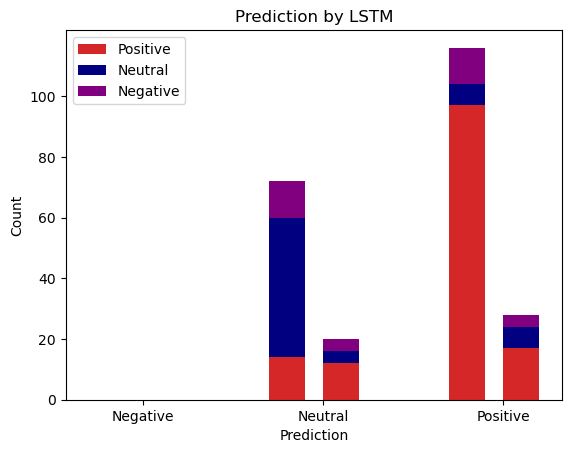

0.6949152542372882


In [353]:
plot_prediction_test_train_bar('Predicted_LSTM',X_train.index,X_test.index,'LSTM')
print(accuracy_score(df['label'],df['Predicted_LSTM']))